# The Battle of Neighbourhoods 

## 1. Introduction 
In this project, we will adopt machine learning tools to cluster Toronto and Shanghai neighborhoods in order to recommend the neighborhoods which are the best choices for migrants based on surrounded essential facilities such as school, hospital, and stores etc. <br><br>
We will be using two datasets for this project: The first dataset toront.csv consists of Toronto’s boroughs, Neighbourhoods and their respective postcodes. The second dataset shanghai.csv consists of Shanghai’s city name, districts and subdistrict. Both datasets were scraped from Wikipedia page. <br><br>
Foursquare API provides access to massive datasets of location data and venues information including address, images, tips, ratings and comments. In this project, we will use Foursquare API and Geopy data to locate nearby venues within 500 meters of each neighbourhood in Toronto and Shanghai.

In [13]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 
from pandas.io.json import json_normalize
import matplotlib.cm as cm 
import matplotlib.colors as colors
import requests 
import folium # map rendering library

# pip install geopy # uncomment this line if you haven't if you haven't install geopy 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# pip install sklearn # uncomment this line if you haven't install sklearn   
from sklearn.cluster import KMeans

<br> 
## 2. Data 

### 2.1 Data Collection 
Toronto and Shanghai neighbourhoods data was scraped from Wikipedia page and converted into pandas dataframe. <br>
A csv file that has the geographical coordinates of each postal code for neighbourhoods in Toronto is provided. <br>
All the files can be found in the github page: https://github.com/wei955/The-Battle-of-Neighborhoods <br>
 

### 2.2 Data Cleaning

<font size="4">**Toronto**</font><br>
Let's load Toronto dataframe and clean up the data.

In [14]:
toronto = pd.read_csv('toronto.csv')
toronto.head()

,PostalCode,Borough,Neighbourhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


Ignore cells with a borough that is Not assigned.

In [15]:
indexNames = toronto[ toronto['Borough'] =='Not assigned'].index
toronto.drop(indexNames , inplace=True)
toronto.head(10)

,PostalCode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government
8,M9A,Etobicoke,Islington Avenue
9,M1B,Scarborough,Malvern / Rouge
11,M3B,North York,Don Mills
12,M4B,East York,Parkview Hill / Woodbine Gardens
13,M5B,Downtown Toronto,Garden District


If a cell has a borough but a Not assigned Neighbourhood, then the Neighbourhood will be the same as the borough.

In [16]:
toronto.loc[toronto['Neighbourhood'] =='Not assigned' , 'Neighbourhood'] = toronto['Borough']
toronto.head()

,PostalCode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


In [17]:
toronto.shape

(103, 3)

<font size="4">**Shanghai**</font><br>

Now, Let's load Shanghai dataset.

In [18]:
shanghai = pd.read_csv('shanghai.csv')
shanghai.rename(columns={'District':'Borough','Subdistrict':'Neighbourhood'}, inplace=True)
shanghai.head()

,City,Borough,Neighbourhood
0,Shanghai,Baoshan,Wusong
1,Shanghai,Baoshan,Youyi
2,Shanghai,Baoshan,Zhangmiao
3,Shanghai,Baoshan,Dachang
4,Shanghai,Baoshan,Gaojing


In [19]:
shanghai.shape

(231, 3)

<br><br>
## 3. Methodology 

### 3.1 Obtain Coordinates 

<font size="4">**Toronto**</font><br>
Given that Geocoder package can be very unreliable, we will use a csv file that has the geographical coordinates of each postal code.

In [290]:
df_lon_lat = pd.read_csv('Geospatial_Coordinates.csv')
df_lon_lat.columns = ['PostalCode', 'Latitude', 'Longitude']
df_lon_lat.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merge Toronto data and coordinates in one single dataframe.

In [291]:
df_toronto = pd.merge(toronto, df_lon_lat[['PostalCode','Latitude', 'Longitude']], on='PostalCode')
df_toronto.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636
3,M6A,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494


Now, let's replace the PostalCode column with city name.

In [292]:
df_toronto = df_toronto.drop(['PostalCode'], axis=1)
df_toronto.insert(0, 'City', 'Toronto')
df_toronto.head()

,City,Borough,Neighbourhood,Latitude,Longitude
0,Toronto,North York,Parkwoods,43.753259,-79.329656
1,Toronto,North York,Victoria Village,43.725882,-79.315572
2,Toronto,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636
3,Toronto,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763
4,Toronto,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494


In [293]:
print('The Toronto dataframe has {} boroughs and {} Neighbourhoods.'.format(
        len(df_toronto['Borough'].unique()),
        df_toronto.shape[0]
    )
)

The Toronto dataframe has 10 boroughs and 103 Neighbourhoods.


<font size="4">**Shanghai**</font><br>
For Shanghai dataset, we did not find a file that has the geographical coordinates, so we will use Nominatim API.

In [600]:
# Use geopy library to get the latitude and longitude values of Shanghai.
df_shanghai= pd.DataFrame(columns = ['City','Borough','Neighbourhood'])

for borough, neighbourhood in zip(shanghai['Borough'],shanghai['Neighbourhood']):   
    #find the location data, ignore the neighbourhoods that are unable to be located by Nominatim
    geolocator = Nominatim(user_agent="my-application")
    location = geolocator.geocode("{},{},Shanghai,China".format(neighbourhood,borough))
    
    #try one more searching
    if location is None: 
        location = geolocator.geocode("{},Shanghai,China".format(neighbourhood))
        
    if location is None: 
        print("The location data of {} in {} is not available!".format(neighbourhood,borough))
    else:
        df_shanghai = df_shanghai.append({'City': 'Shanghai',
                                                'Borough': borough,
                                                'Neighbourhood': neighbourhood,
                                                'Latitude': location.latitude,
                                                'Longitude': location.longitude
                                               }, ignore_index=True)

df_shanghai.head()

The location data of Xianhua in Changning is not available!
The location data of Zhoujiaqiao in Changning is not available!
The location data of Shanghai Fengxian Bay Tourism Zone in Fengxian is not available!
The location data of Shanghai Seaport Comprehensive Economic Development Zone in Fengxian is not available!
The location data of Jiangwanzhen in Hongkou is not available!
The location data of Ruijin Second Road in Huangpu is not available!
The location data of Xiaodongmen in Huangpu is not available!
The location data of Juyuan New Area Administrative Committee in Jiading is not available!
The location data of Jingansi in Jingan is not available!
The location data of Shimen Second Road in Jingan is not available!
The location data of Pengpu Town in Jingan is not available!
The location data of Jinshan Industry Zone in Jinshan is not available!
The location data of Pujing in Minhang is not available!
The location data of Wukong in Minhang is not available!
The location data of Nan

,City,Borough,Neighbourhood,Latitude,Longitude
0,Shanghai,Baoshan,Wusong,31.374576,121.489507
1,Shanghai,Baoshan,Youyi,31.406525,121.477742
2,Shanghai,Baoshan,Zhangmiao,31.338535,121.437238
3,Shanghai,Baoshan,Dachang,31.288671,121.412298
4,Shanghai,Baoshan,Gaojing,31.323063,121.478105


In [601]:
print('The Shanghai dataframe has {} boroughs and {} Neighbourhoods.'.format(
        len(df_shanghai['Borough'].unique()),
        df_shanghai.shape[0]
    )
)

The Shanghai dataframe has 16 boroughs and 209 Neighbourhoods.


Let's Merge Toronto and Shanghai neighbourhoods into one dataframe first.

In [710]:
df_toronto_sh =  pd.concat([df_toronto, df_shanghai])
print('There are total {} neighbourhoods in Toronto and Shanghai.'.format(df_toronto_sh.shape[0]))
df_toronto_sh.head()

There are total 312 neighbourhoods in Toronto and Shanghai.


,City,Borough,Neighbourhood,Latitude,Longitude
0,Toronto,North York,Parkwoods,43.753259,-79.329656
1,Toronto,North York,Victoria Village,43.725882,-79.315572
2,Toronto,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636
3,Toronto,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763
4,Toronto,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494


In [709]:
# Let's save the Toronto and Shanghai neighbourhoods with coordiantes to csv files.
# df_toronto.to_csv('toronto_with_coordinates.csv', sep='\t')
# df_shanghai.to_csv('shanghai_with_coordinates.csv', sep='\t')

### <br>3.2 Data Visualization 

Visualize the data with Folium Maps. The neighbourhoods belong to the same borough will be plotted with the same color.

In [603]:
# Define a funciton that creates a map of different neighbourhoods in the city.
def getMap (cityname,countryname,dataframe):
    address = cityname + ',' + countryname

    geolocator = Nominatim(user_agent="my-application")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of ' + cityname + ' are {}, {}.'.format(latitude, longitude))
    
    # create map using latitude and longitude values.
    city_map = folium.Map(location=[latitude, longitude], zoom_start=10)

    # set color scheme for the Borough
    borough_name = dataframe['Borough'].unique().tolist()
    colnum = dataframe['Borough'].unique().size
    x = np.arange(colnum)
    ys = [i+x+(i*x)**2 for i in range(colnum)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    for lat, lon, Neighbourhood, borough in zip(dataframe['Latitude'], dataframe['Longitude'], dataframe['Neighbourhood'], dataframe['Borough']):
        cluster = borough_name.index(borough)
        label = '{}, {}'.format(Neighbourhood, borough)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster],
            fill=True,
            fill_color=rainbow[cluster],
            fill_opacity=0.7).add_to(city_map)  
    return city_map

<br><font size="4">**Toronto**</font> Neighbourhoods.

In [604]:
getMap('Toronto','Canada',df_toronto)

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


<br><font size="4">**Shanghai**</font> Neighbourhoods.

In [605]:
getMap('Shanghai','China',df_shanghai)

The geograpical coordinate of Shanghai are 31.2322758, 121.4692071.


By looking at the map, there are three outliers do not lie into their boroughs due to wrong location data. Let's clean it out.

In [122]:
df_shanghai = df_shanghai[df_shanghai.Neighbourhood != 'Changzheng']
df_shanghai = df_shanghai[df_shanghai.Neighbourhood != 'Beizhan']
df_shanghai = df_shanghai[df_shanghai.Neighbourhood != 'Chaoyang Farm']
df_shanghai.reset_index(drop=True,inplace=True)

getMap('Shanghai','China', df_shanghai)

The geograpical coordinate of Shanghai are 31.2322758, 121.4692071.


Now the map is clean.

### <br> 3.3  Use Foursquare API for Venues

Define Foursquare Credentials and Version.

In [192]:
CLIENT_ID = 'RYKIRZIKVTTDHOOK2OH04HC4XNYPYVCV44RSMTF0ZBCJE4E5' 
CLIENT_SECRET = 'HVJBGVHUNMTZUIA1RJOJOWPJSGQZSGNZ0MQKHU2KE1PI0YTE' 
VERSION = '20200425' 

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RYKIRZIKVTTDHOOK2OH04HC4XNYPYVCV44RSMTF0ZBCJE4E5
CLIENT_SECRET:HVJBGVHUNMTZUIA1RJOJOWPJSGQZSGNZ0MQKHU2KE1PI0YTE


Create a function to get nearby venues of all the neighbourhoods in the city.

In [199]:
def getNearbyVenues(cities, boroughs, neighbourhoods, latitudes, longitudes, radius=500):
    
    # Define limit of venues to get
    LIMIT = 100
    
    venues_list=[]
    for city, borough, neighbourhood, lat, lng in zip(cities, boroughs, neighbourhoods, latitudes, longitudes):
        print(neighbourhood)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(city, 
            borough, 
            neighbourhood, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City',
                  'Borough',          
                  'Neighbourhood', 
                  'Latitude', 
                  'Longitude', 
                  'Venue',  
                  'Venue Category']
    
    return(nearby_venues)

<br><font size="4">**Toronto**</font><br>

Call the getNearbyVenues function on each Neibourhood and create a new dataframe called toronto_venues.

In [200]:
toronto_venues = getNearbyVenues(df_toronto['City'], df_toronto['Borough'], 
                                 df_toronto['Neighbourhood'], df_toronto['Latitude'],
                                 df_toronto['Longitude']
                                )

Parkwoods
Victoria Village
Regent Park / Harbourfront
Lawrence Manor / Lawrence Heights
Queen's Park / Ontario Provincial Government
Islington Avenue
Malvern / Rouge
Don Mills
Parkview Hill / Woodbine Gardens
Garden District
Glencairn
West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale
Rouge Hill / Port Union / Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate / Bloordale Gardens / Old Burnhamthorpe / Markland Wood
Guildwood / Morningside / West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor / Wilson Heights / Downsview North
Thorncliffe Park
Richmond / Adelaide / King
Dufferin / Dovercourt Village
Scarborough Village
Fairview / Henry Farm / Oriole
Northwood Park / York University
East Toronto
Harbourfront East / Union Station / Toronto Islands
Little Portugal / Trinity
Kennedy Park / Ionview / East Birchmount Park
Bayview Village
Downsview
T

Check the size of the dataframe.

In [201]:
print(toronto_venues.shape)
toronto_venues.head()

(2129, 7)


,City,Borough,Neighbourhood,Latitude,Longitude,Venue,Venue Category
0,Toronto,North York,Parkwoods,43.753259,-79.329656,Brookbanks Park,Park
1,Toronto,North York,Parkwoods,43.753259,-79.329656,Variety Store,Food & Drink Shop
2,Toronto,North York,Parkwoods,43.753259,-79.329656,Corrosion Service Company Limited,Construction & Landscaping
3,Toronto,North York,Victoria Village,43.725882,-79.315572,Victoria Village Arena,Hockey Arena
4,Toronto,North York,Victoria Village,43.725882,-79.315572,Tim Hortons,Coffee Shop


Check how many venues were returned for each Neiborhood.

In [202]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))
toronto_venues.groupby('Neighbourhood').count()

There are 269 uniques categories.


,City,Borough,Latitude,Longitude,Venue,Venue Category
Neighbourhood,,,,,,
Agincourt,3,3,3,3,3,3
Alderwood / Long Branch,8,8,8,8,8,8
Bathurst Manor / Wilson Heights / Downsview North,21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
Bedford Park / Lawrence Manor East,24,24,24,24,24,24
Berczy Park,58,58,58,58,58,58
Birch Cliff / Cliffside West,4,4,4,4,4,4
Brockton / Parkdale Village / Exhibition Place,23,23,23,23,23,23
Business reply mail Processing CentrE,16,16,16,16,16,16


<font size="4">**Shanghai**</font><br>

Let's repeat the same process for Shanghai data.

In [203]:
shanghai_venues = getNearbyVenues(df_shanghai['City'], df_shanghai['Borough'], 
                                 df_shanghai['Neighbourhood'], df_shanghai['Latitude'],
                                 df_shanghai['Longitude']
                                )

Wusong
Youyi
Zhangmiao
Dachang
Gaojing
Gucun
Luodian
Luojing
Miaohang
Songnan
Yanghang
Yuepu
Baoshan City Industrial Park
Beixinjing
Chengjiaqiao
Hongqiao
Huayang Road
Jiangsu Road
Tianshan Road
Xianxia
Xinjing
Xidu
Fengcheng
Haiwan
Jinhui
Nanqiao
Qingcun
Situan
Zhelin
Zhuanghang
Fengpu
Jinhai
Guangzhong Road
Jiaxing
Liangcheng
North Sichuan Road
Ouyang Road
Quyang Road
Tilanqiao
Bansongyuan Road
Central Huaihai Road
Dapuqiao
East Nanjing Road
Laoximen
Wuliqiao
Yuyuan
Jiadingzhen
Xincheng Road
Zhenxin
Anting
Huating
Jiangqiao
Malu
Nanxiang
Waigang
Xuhang
Jiading Industrial Zone
Baoshan Road
Caojiadu
Daning Road
Gonghexin Road
Jiangning Road
Linfen Road
Pengpu 
West Nanjing Road
West Tianmu Road
West Zhijiang Road
Shihua
Caojing
Fengjing
Jinshanwei
Langxia
Lvxiang
Shanyang
Tinglin
Zhangyan
Zhujing
Gumei Road
Jiangchuan Road
Xinhong
Hongqiao
Huacao
Maqiao
Meilong
Qibao
Pujiang
Xinzhuang
Zhuanqiao
Xinzhuang Industrial Zone
Dongming Road
Huamu
Hudong 
Jinyang
Lujiazui
Nanmatou
Puxing Road


Check the size of the dataframe.

In [205]:
print(shanghai_venues.shape)
shanghai_venues.head()

(1449, 7)


,City,Borough,Neighbourhood,Latitude,Longitude,Venue,Venue Category
0,Shanghai,Baoshan,Wusong,31.374576,121.489507,85°C Bakery Café (85度C),Bakery
1,Shanghai,Baoshan,Wusong,31.374576,121.489507,Songbin Road Metro Station (淞滨路地铁站),Metro Station
2,Shanghai,Baoshan,Wusong,31.374576,121.489507,外环隧道,Tunnel
3,Shanghai,Baoshan,Wusong,31.374576,121.489507,吴淞码头,General Travel
4,Shanghai,Baoshan,Youyi,31.406525,121.477742,Starbucks (星巴克),Coffee Shop


Check how many venues were returned for each Neiborhood.

In [826]:
print('There are {} uniques categories.'.format(len(shanghai_venues['Venue Category'].unique())))
shanghai_venues.groupby('Neighbourhood').count()

There are 202 uniques categories.


,City,Borough,Latitude,Longitude,Venue,Venue Category
Neighbourhood,,,,,,
Anting,5,5,5,5,5,5
Bansongyuan Road,9,9,9,9,9,9
Baoshan City Industrial Park,1,1,1,1,1,1
Baoshan Road,9,9,9,9,9,9
Beicai,6,6,6,6,6,6
Beixinjing,11,11,11,11,11,11
Caohejing,2,2,2,2,2,2
Caohejing Hi-Tech Park,7,7,7,7,7,7
Caojiadu,29,29,29,29,29,29


<br><font size="4">**Merge Toronto and Shanghai Venues into one dataframe.**</font><br>

In [1067]:
toronto_sh_venues =  pd.concat([toronto_venues,shanghai_venues])
print(toronto_sh_venues.shape)
toronto_sh_venues.head()

(3578, 7)


,City,Borough,Neighbourhood,Latitude,Longitude,Venue,Venue Category
0,Toronto,North York,Parkwoods,43.753259,-79.329656,Brookbanks Park,Park
1,Toronto,North York,Parkwoods,43.753259,-79.329656,Variety Store,Food & Drink Shop
2,Toronto,North York,Parkwoods,43.753259,-79.329656,Corrosion Service Company Limited,Construction & Landscaping
3,Toronto,North York,Victoria Village,43.725882,-79.315572,Victoria Village Arena,Hockey Arena
4,Toronto,North York,Victoria Village,43.725882,-79.315572,Tim Hortons,Coffee Shop


Since almost all the restaurants in Shanghai are Chinese restaurants, we will change all types of restaurants such as 'French Restaurant', 'Pizza Place' and 'Sichuan Restaurant'into 'Restaurant'.

In [1068]:
toronto_sh_venues.loc[toronto_sh_venues['Venue Category'].str.contains('Restaurant', case=False), 'Venue Category'] = 'Restaurant'
print(toronto_sh_venues.shape)
toronto_sh_venues.head(10)


(3578, 7)


,City,Borough,Neighbourhood,Latitude,Longitude,Venue,Venue Category
0,Toronto,North York,Parkwoods,43.753259,-79.329656,Brookbanks Park,Park
1,Toronto,North York,Parkwoods,43.753259,-79.329656,Variety Store,Food & Drink Shop
2,Toronto,North York,Parkwoods,43.753259,-79.329656,Corrosion Service Company Limited,Construction & Landscaping
3,Toronto,North York,Victoria Village,43.725882,-79.315572,Victoria Village Arena,Hockey Arena
4,Toronto,North York,Victoria Village,43.725882,-79.315572,Tim Hortons,Coffee Shop
5,Toronto,North York,Victoria Village,43.725882,-79.315572,Portugril,Restaurant
6,Toronto,North York,Victoria Village,43.725882,-79.315572,The Frig,Restaurant
7,Toronto,North York,Victoria Village,43.725882,-79.315572,Eglinton Ave E & Sloane Ave/Bermondsey Rd,Intersection
8,Toronto,North York,Victoria Village,43.725882,-79.315572,Pizza Nova,Pizza Place
9,Toronto,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636,Roselle Desserts,Bakery


Peform one-hot encoding.

In [1069]:
toronto_sh_onehot = pd.get_dummies(toronto_sh_venues[['Venue Category']], prefix="", prefix_sep="")

# add Neighbourhood column back to dataframe
toronto_sh_onehot['Neighbourhood'] = toronto_sh_venues['Neighbourhood'] 

# move Neighbourhood column to the first column
fixed_columns = [toronto_sh_onehot.columns[-1]] + list(toronto_sh_onehot.columns[:-1])
print(toronto_sh_onehot.shape)
toronto_sh_onehot.head()

(3578, 267)


,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cable Car,Café,Camera Store,Campground,Candy Store,Cemetery,Cha Chaan Teng,Cheese Shop,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cupcake Shop,Curling Ice,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Donut Shop,Drugstore,Electronics Store,Event Space,Fabric Shop,Farmers Market,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fountain,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotel Pool,Housing Development,IT Services,Ice Cream Shop,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Lake,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Men's Store,Metro Station,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,Night Market,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Pier,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Post Office,Poutine Place,Pub,Racetrack,Record Shop,Recreation Center,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sauna / Steam Room,Scenic Lookout,Sculpture Garden,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Strip Club,Supermarket,Supplement Shop,Swim School,Taco Place,Tailor Shop,Tanning Salon,Tea Room,Tennis Court,Theater,Theme Park,Toy / Game Store,Trail,Train Station,Tram Station,Travel & Transport,Tunnel,Video Game Store,Video Store,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Neighbourhood
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Parkwoods
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

Now we need to clean the colums. For example, 'Art Gallery' and 'Art Museum' are basically in the same category.

In [1070]:
def clean_columns(columns,newcolumnname,dataframe):
    value = 0
    for column in columns:
        value = dataframe[column] + value
    
    dataframe = dataframe.drop(columns,axis = 1)
    dataframe[newcolumnname] = value
    
    return dataframe

columns = ['Art Gallery', 'Art Museum', 'Arts & Crafts Store','Museum','Street Art']
newcolumnname = 'Art Museum'
toronto_sh_onehot = clean_columns(columns,newcolumnname,toronto_sh_onehot)

columns = ['Baseball Field','Baseball Stadium']
newcolumnname = 'Baseball Field'
toronto_sh_onehot = clean_columns(columns,newcolumnname,toronto_sh_onehot)

columns = ['Basketball Court', 'Basketball Stadium']
newcolumnname = 'Basketball Stadium'
toronto_sh_onehot = clean_columns(columns,newcolumnname,toronto_sh_onehot)

columns = ['Soccer Field', 'Soccer Stadium','Stadium']
newcolumnname = 'Stadium'
toronto_sh_onehot = clean_columns(columns,newcolumnname,toronto_sh_onehot)

columns = ['Bar','Beer Bar','Beer Garden', 'Beer Store','Cocktail Bar','Whisky Bar', 'Wine Bar','Sake Bar','Hotel Bar', 'Dive Bar']
newcolumnname = 'Bar'
toronto_sh_onehot = clean_columns(columns,newcolumnname,toronto_sh_onehot)

columns = ['Wine Shop','Liquor Store']
newcolumnname = 'Liquor'
toronto_sh_onehot = clean_columns(columns,newcolumnname,toronto_sh_onehot)

columns = ['Bus Line', 'Bus Station','Bus Stop']
newcolumnname = 'Bus Statiion'
toronto_sh_onehot = clean_columns(columns,newcolumnname,toronto_sh_onehot)

columns = ['Café','Coffee Shop','Gaming Cafe']
newcolumnname = 'Cafeteria'
toronto_sh_onehot = clean_columns(columns,newcolumnname,toronto_sh_onehot)

columns = ['Food', 'Food & Drink Shop','Food Court','Food Truck', 'Street Food Gathering']
newcolumnname = 'Street Food'
toronto_sh_onehot = clean_columns(columns,newcolumnname,toronto_sh_onehot)
  
columns = ['Shopping Mall', 'Shopping Plaza']
newcolumnname = 'Shopping Mall'
toronto_sh_onehot = clean_columns(columns,newcolumnname,toronto_sh_onehot)

columns = ['Drugstore','Pharmacy']
newcolumnname = 'Pharmacy'
toronto_sh_onehot = clean_columns(columns,newcolumnname,toronto_sh_onehot)

columns = ['Sporting Goods Shop', 'Sports Bar']
newcolumnname = 'Sports'
toronto_sh_onehot = clean_columns(columns,newcolumnname,toronto_sh_onehot)

columns = ['Gym','Gym / Fitness Center', 'Gym Pool']
newcolumnname = 'Gym'
toronto_sh_onehot = clean_columns(columns,newcolumnname,toronto_sh_onehot)

columns = ['Hostel','Hotel','Motel']
newcolumnname = 'Hotel'
toronto_sh_onehot = clean_columns(columns,newcolumnname,toronto_sh_onehot)

Group rows by Neighbourhood and by taking the mean of the frequency of occurrence of each category.

In [1071]:
toronto_sh_grouped = toronto_sh_onehot.groupby('Neighbourhood').mean().reset_index()
print(toronto_sh_grouped.shape)
toronto_sh_grouped.head()

(250, 234)


,Neighbourhood,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Antique Shop,Aquarium,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Beach,Bed & Breakfast,Big Box Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Burger Joint,Burrito Place,Business Center,Business Service,Butcher,Cable Car,Camera Store,Campground,Candy Store,Cemetery,Cha Chaan Teng,Cheese Shop,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cupcake Shop,Curling Ice,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Electronics Store,Event Space,Fabric Shop,Farmers Market,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Football Stadium,Fountain,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel Pool,Housing Development,IT Services,Ice Cream Shop,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Lake,Light Rail Station,Lingerie Store,Locksmith,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Men's Store,Metro Station,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Music Store,Music Venue,Nail Salon,Neighborhood,Night Market,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pier,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Post Office,Poutine Place,Pub,Racetrack,Record Shop,Recreation Center,Rental Car Location,Restaurant,River,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Sauna / Steam Room,Scenic Lookout,Sculpture Garden,Shoe Store,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Social Club,Soup Place,Spa,Speakeasy,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Swim School,Taco Place,Tailor Shop,Tanning Salon,Tea Room,Tennis Court,Theater,Theme Park,Toy / Game Store,Trail,Train Station,Tram Station,Travel & Transport,Tunnel,Video Game Store,Video Store,Warehouse Store,Waterfront,Wings Joint,Women's Store,Yoga Studio,Art Museum,Baseball Field,Basketball Stadium,Stadium,Bar,Liquor,Bus Statiion,Cafeteria,Street Food,Shopping Mall,Pharmacy,Sports,Gym,Hotel
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.000,0.0
1,Al

Print each Neighbourhood along with the top 5 most common venues.

In [1072]:
num_top_venues = 5

for hood in toronto_sh_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_sh_grouped[toronto_sh_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
            venue  freq
0      Restaurant  0.33
1  Breakfast Spot  0.33
2          Lounge  0.33
3            Pier  0.00
4    Noodle House  0.00


----Alderwood / Long Branch----
            venue  freq
0     Pizza Place  0.25
1    Skating Rink  0.12
2             Pub  0.12
3       Cafeteria  0.12
4  Sandwich Place  0.12


----Anting----
          venue  freq
0    Restaurant   0.8
1          Park   0.2
2          Pier   0.0
3     Nightclub   0.0
4  Noodle House   0.0


----Bansongyuan Road----
               venue  freq
0          Cafeteria  0.44
1         Restaurant  0.33
2         Art Museum  0.22
3  Accessories Store  0.00
4          Pet Store  0.00


----Baoshan City Industrial Park----
               venue  freq
0   Business Service   1.0
1  Accessories Store   0.0
2               Pier   0.0
3       Noodle House   0.0
4             Office   0.0


----Baoshan Road----
               venue  freq
0         Restaurant  0.22
1      Shopping Mall  0.11
2     History Mus

                venue  freq
0   Convenience Store   0.4
1      History Museum   0.2
2  Basketball Stadium   0.2
3          Restaurant   0.2
4           Juice Bar   0.0


----Gaohang----
               venue  freq
0         Restaurant  0.25
1      Shopping Mall  0.25
2      Movie Theater  0.25
3      Big Box Store  0.25
4  Accessories Store  0.00


----Gaojing----
               venue  freq
0         Restaurant  0.25
1      Shopping Mall  0.25
2         Hotel Pool  0.25
3      Metro Station  0.25
4  Accessories Store  0.00


----Gaoqiao----
          venue  freq
0    Restaurant   0.6
1         Hotel   0.4
2     Irish Pub   0.0
3     Jazz Club   0.0
4  Noodle House   0.0


----Garden District----
             venue  freq
0       Restaurant  0.23
1        Cafeteria  0.13
2   Clothing Store  0.09
3   Cosmetics Shop  0.03
4  Bubble Tea Shop  0.03


----Glencairn----
               venue  freq
0         Restaurant  0.50
1                Pub  0.25
2        Pizza Place  0.25
3  Recreation Cent

               venue  freq
0               Park   0.5
1         Playground   0.5
2  Accessories Store   0.0
3               Pier   0.0
4          Nightclub   0.0


----Mimico NW / The Queensway West / South of Bloor / Kingsway Park South West / Royal York South West----
             venue  freq
0     Burger Joint  0.07
1   Sandwich Place  0.07
2    Burrito Place  0.07
3  Supplement Shop  0.07
4      Flower Shop  0.07


----Moore Park / Summerhill East----
                   venue  freq
0           Tennis Court  0.25
1             Playground  0.25
2                   Park  0.25
3             Restaurant  0.25
4  Performing Arts Venue  0.00


----Nanmatou----
           venue  freq
0     Restaurant  0.67
1  Metro Station  0.33
2           Pier  0.00
3   Noodle House  0.00
4         Office  0.00


----Nanqiao----
               venue  freq
0         Restaurant   0.6
1              Hotel   0.2
2  Convenience Store   0.2
3             Sports   0.0
4       Neighborhood   0.0


----Nanxiang---

4  Convenience Store  0.04


----West Tianmu Road----
        venue  freq
0  Restaurant  0.38
1   Cafeteria  0.18
2       Hotel  0.15
3      Lounge  0.06
4         Bar  0.03


----West Zhijiang Road----
           venue  freq
0     Restaurant  0.44
1   Bus Statiion  0.22
2   Noodle House  0.11
3  Shopping Mall  0.11
4      Cafeteria  0.11


----Westmount----
               venue  freq
0        Pizza Place  0.33
1         Restaurant  0.33
2     Sandwich Place  0.17
3          Cafeteria  0.17
4  Recreation Center  0.00


----Weston----
               venue  freq
0  Convenience Store   1.0
1               Pier   0.0
2          Nightclub   0.0
3       Noodle House   0.0
4             Office   0.0


----Wexford / Maryvale----
            venue  freq
0      Restaurant  0.25
1  Breakfast Spot  0.25
2      Smoke Shop  0.25
3          Bakery  0.25
4            Pier  0.00


----Willowdale----
            venue  freq
0      Restaurant  0.32
1       Cafeteria  0.13
2     Pizza Place  0.08
3  Sandw

Write a function to sort the venues in descending order.

In [1073]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

 Create the new dataframe and display the top 10 venues for each Neighbourhood.

In [1074]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
toronto_sh_venues_sorted = pd.DataFrame(columns=columns)
toronto_sh_venues_sorted['Neighbourhood'] = toronto_sh_grouped['Neighbourhood']

for ind in np.arange(toronto_sh_grouped.shape[0]):
    toronto_sh_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_sh_grouped.iloc[ind, :], num_top_venues)

print(toronto_sh_venues_sorted.shape)    
toronto_sh_venues_sorted.head(10)

(250, 11)


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Restaurant,Breakfast Spot,Lounge,Distribution Center,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Farmers Market
1,Alderwood / Long Branch,Pizza Place,Pub,Gym,Sandwich Place,Cafeteria,Skating Rink,Pharmacy,Field,Farmers Market,Fabric Shop
2,Anting,Restaurant,Park,Distribution Center,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Farmers Market,Fabric Shop
3,Bansongyuan Road,Cafeteria,Restaurant,Art Museum,Hotel,Fabric Shop,Dog Run,Donut Shop,Electronics Store,Event Space,Field
4,Baoshan City Industrial Park,Business Service,Hotel,Dog Run,Football Stadium,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Farmers Market
5,Baoshan Road,Restaurant,Convenience Store,Cafeteria,Electronics Store,Dance Studio,Metro Station,History Museum,Shopping Mall,Fish & Chips Shop,Field
6,Bathurst Manor / Wilson Heights / Downsview North,Restaurant,Cafeteria,Bank,Bridal Shop,Video Store,Pizza Place,Pet Store,Sandwich Place,Deli / Bodega,Diner
7,Bayview Village,Restaurant,Cafeteria,Bank,Distribution Center,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Farmers Market
8,Bedford Park / Lawrence Manor East,Restaurant,Cafeteria,Pizza Place,Sandwich Place,Pharmacy,Pub,Cosmetics Shop,Liquor,Butcher,Juice Bar
9,Beicai,Restaurant,Hotel,Bus Statiion,Mobile Phone Shop,Ice Cream Shop,Airport Lounge,Convention Center,Fountain,Football Stadium,Flower Shop


## <br> 3.4 Machine Learning Model

We will apply K-Means model to segment and cluster all the neighborhoods in Toronto and Shanghai. <br>
First, we use Elbow Method to determine the value of K.

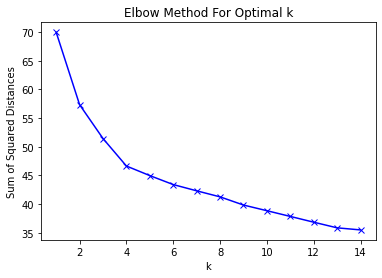

In [1075]:
import sklearn
import matplotlib.pyplot as plt

Sum_of_squared_distances = []
K = range(1, 15)
toronto_sh_grouped_clustering = toronto_sh_grouped.drop('Neighbourhood', 1)

for kvalues in K:
    km = KMeans(n_clusters=kvalues, init='k-means++', n_init=10, max_iter=300, tol=0.0001,  random_state=10).fit(toronto_sh_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The elbow point of the line chart is determined as the right K for clustering. Here K equals to 4.

<font size="3">**Run K-Means to cluster all the neighborhoods in Toronto and Shanghai into 8 clusters.**</font><br>

In [1076]:
# set number of clusters to 3
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_sh_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([3, 1, 2, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 2,
       3, 3, 3, 3, 2, 3, 1, 3, 0, 2, 3, 2, 1, 1, 3, 3, 3, 0, 3, 1, 3, 3,
       3, 1, 3, 1, 3, 2, 1, 2, 1, 1, 3, 1, 1, 1, 3, 2, 3, 3, 3, 1, 1, 3,
       3, 3, 3, 3, 1, 0, 1, 1, 3, 1, 2, 0, 1, 2, 0, 3, 3, 3, 3, 3, 1, 3,
       0, 1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3,
       1, 3, 2, 3, 1, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 2, 3, 3, 1, 1, 1,
       3, 2, 3, 1, 3, 1, 3, 3, 1, 3, 1, 1, 3, 1, 1, 3, 2, 1, 0, 3, 3, 1,
       1, 3, 1, 1, 1, 3, 1, 2, 1, 1, 2, 2, 2, 0, 0, 2, 2, 3, 3, 1, 1, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 0, 3, 2, 1, 3, 2, 1, 1, 3, 1, 3,
       0, 1, 3, 3, 0, 1, 3, 2, 3, 0, 3, 3, 1, 3, 2, 3, 3, 3, 3, 3, 1, 2,
       2, 1, 3, 3, 2, 1, 1, 0], dtype=int32)

Create a new dataframe that includes the cluster as well as the top 10 venues for each Neighbourhood in Toronto and Shanghai.

In [1077]:
# add clustering labels
toronto_sh_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)

toronto_sh_merged = df_toronto_sh

# merge sorted venues with df_toronto_sh to add latitude/longitude for each Neighbourhood
toronto_sh_merged = toronto_sh_merged.join(toronto_sh_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

#Drop the rows that have no data.
toronto_sh_merged=toronto_sh_merged.dropna()
toronto_sh_merged.shape

print(toronto_sh_merged.shape)
toronto_sh_merged.head(10)

(256, 16)


,City,Borough,Neighbourhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Toronto,North York,Parkwoods,43.753259,-79.329656,1.0,Construction & Landscaping,Street Food,Park,Distribution Center,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Farmers Market
1,Toronto,North York,Victoria Village,43.725882,-79.315572,3.0,Restaurant,Pizza Place,Intersection,Cafeteria,Hockey Arena,Event Space,Distribution Center,Dog Run,Donut Shop,Electronics Store
2,Toronto,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636,1.0,Cafeteria,Restaurant,Park,Pub,Bakery,Breakfast Spot,Theater,Hotel,Event Space,Electronics Store
3,Toronto,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763,1.0,Clothing Store,Furniture / Home Store,Women's Store,Accessories Store,Event Space,Miscellaneous Shop,Boutique,Cafeteria,Restaurant,Field
4,Toronto,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494,3.0,Cafeteria,Restaurant,Diner,Bar,Park,Juice Bar,Fried Chicken Joint,Theater,Distribution Center,Discount Store
6,Toronto,Scarborough,Malvern / Rouge,43.806686,-79.194353,2.0,Restaurant,Distribution Center,Football Stadium,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Farmers Market,Fabric Shop
7,Toronto,North York,Don Mills,43.745906,-79.352188,3.0,Restaurant,Cafeteria,Gym,Bar,Concert Hall,Bike Shop,Discount Store,Sandwich Place,Clothing Store,Supermarket
8,Toronto,East York,Parkview Hill / Woodbine Gardens,43.706397,-79.309937,1.0,Pizza Place,Pet Store,Pharmacy,Gym,Restaurant,Intersection,Bank,Gastropub,Athletics & Sports,Electronics Store
9,Toronto,Downtown Toronto,Garden District,43.657162,-79.378937,3.0,Restaurant,Cafeteria,Clothing Store,Cosmetics Shop,Bubble Tea Shop,Hotel,Gym,Diner,Bookstore,Tea Room
10,Toronto,North York,Glencairn,43.709577,-79.445073,3.0,Restaurant,Pub,Pizza Place,Discount Store,Flea Market,Fish Market,Fish & Chips Shop,Field,Farmers Market,Fabric Shop


Define a function to visualize the resulting clusters.

In [1078]:
def displayClusters(city, country, dataframe):

    address = city + ',' + country

    geolocator = Nominatim(user_agent="my-application")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    cluster_map = folium.Map(location=[latitude, longitude], zoom_start=10)

    # set color scheme for the Cluster_Labels
    x = np.arange(kclusters)
    ys = [i+x+(i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    for lat, lon, neighbourhood, borough, cluster_labels in zip(dataframe['Latitude'], 
                                                                dataframe['Longitude'], 
                                                                dataframe['Neighbourhood'], 
                                                                dataframe['Borough'],
                                                                dataframe['Cluster_Labels']):
        cluster = int(cluster_labels)
        label = '{}, {},Cluster {}'.format(neighbourhood, borough, cluster)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster],
            fill=True,
            fill_color=rainbow[cluster],
            fill_opacity=0.7).add_to(cluster_map)
    return cluster_map

## <br> 4. Results

<font size="3">**Examine and distinguish each cluster.**</font><br>

Let's check the total number of neighborhoods in each cluster.

In [1079]:
for cluster_num in range(4):
    num_of_nbh = toronto_sh_merged[toronto_sh_merged['Cluster_Labels'] == cluster_num].shape[0]
    print('The number of neighbourhoods in cluster {} is {}'.format(cluster_num+1, num_of_nbh))

The number of neighbourhoods in cluster 1 is 14
The number of neighbourhoods in cluster 2 is 85
The number of neighbourhoods in cluster 3 is 27
The number of neighbourhoods in cluster 4 is 130


<br><font size="4">**Cluster 1**</font>
<br>Mostly suburb areas where have access to hotels, airports and football stadium.

In [1080]:
cluster1 = toronto_sh_merged.loc[toronto_sh_merged['Cluster_Labels'] == 0]
print('There are {} neighborhoods in cluster 1'.format(cluster1.shape[0]))
cluster1

There are 14 neighborhoods in cluster 1


,City,Borough,Neighbourhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
51,Toronto,Scarborough,Cliffside / Cliffcrest / Scarborough Village West,43.716316,-79.239476,0.0,Hotel,Restaurant,Airport,Fried Chicken Joint,Football Stadium,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field
10,Shanghai,Baoshan,Yanghang,31.366469,121.433772,0.0,Hotel,Cafeteria,Big Box Store,Dog Run,Football Stadium,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field
23,Shanghai,Fengxian,Haiwan,30.862943,121.563245,0.0,Hotel,Distribution Center,Football Stadium,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Farmers Market,Fabric Shop
61,Shanghai,Jingan,Gonghexin Road,31.246756,121.458035,0.0,Hotel,Flea Market,Restaurant,Airport Food Court,Fried Chicken Joint,Football Stadium,Flower Shop,Airport,Fish Market,Fish & Chips Shop
68,Shanghai,Jinshan,Shihua,30.727871,121.332173,0.0,Hotel,Distribution Center,Football Stadium,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Farmers Market,Fabric Shop
109,Shanghai,Pudong,Heqing,31.239458,121.719039,0.0,Hotel,Mobile Phone Shop,Dog Run,Football Stadium,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Farmers Market
110,Shanghai,Pudong,Huinan,31.049750,121.745087,0.0,Hotel,Convenience Store,Housing Development,Hotel Pool,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Farmers Market
120,Shanghai,Pudong,Xuanqiao,31.037702,121.690225,0.0,Hotel,Distribution Center,Football Stadium,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Farmers Market,Fabric Shop
123,Shanghai,Pudong,Zhuqiao,31.117293,121.752618,0.0,Hotel,Gym,Airport,Frozen Yogurt Shop,Fountain,Football Stadium,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop
133,Shanghai,Putuo,Shiquan Road,31.248573,121.411431,0.0,Hotel,Furniture / Home Store,Restaurant,Airport Food Court,Fried Chicken Joint,Football Stadium,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop


In [1081]:
print('Toronto:')
displayClusters('Toronto', 'Canada', cluster1[cluster1['City'] == 'Toronto'])

Toronto:


In [1082]:
print('Shanghai:')
displayClusters('Shanghai', 'China', cluster1[cluster1['City'] == 'Shanghai'])

Shanghai:


<br><font size="4">**Cluster 2**</font>
<br>Basically are residential areas with parks, grocery stores, pharmacy and restaurants.

In [1083]:
cluster2 = toronto_sh_merged.loc[toronto_sh_merged['Cluster_Labels'] == 1]
print('There are {} neighborhoods in cluster 2'.format(cluster2.shape[0]))
cluster2

There are 85 neighborhoods in cluster 2


,City,Borough,Neighbourhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Toronto,North York,Parkwoods,43.753259,-79.329656,1.0,Construction & Landscaping,Street Food,Park,Distribution Center,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Farmers Market
2,Toronto,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636,1.0,Cafeteria,Restaurant,Park,Pub,Bakery,Breakfast Spot,Theater,Hotel,Event Space,Electronics Store
3,Toronto,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763,1.0,Clothing Store,Furniture / Home Store,Women's Store,Accessories Store,Event Space,Miscellaneous Shop,Boutique,Cafeteria,Restaurant,Field
8,Toronto,East York,Parkview Hill / Woodbine Gardens,43.706397,-79.309937,1.0,Pizza Place,Pet Store,Pharmacy,Gym,Restaurant,Intersection,Bank,Gastropub,Athletics & Sports,Electronics Store
12,Toronto,Scarborough,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497,1.0,Bar,Hotel,Distribution Center,Football Stadium,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Farmers Market
14,Toronto,East York,Woodbine Heights,43.695344,-79.318389,1.0,Curling Ice,Bus Statiion,Video Store,Park,Athletics & Sports,Bar,Skating Rink,Cosmetics Shop,Pharmacy,Field
16,Toronto,York,Humewood-Cedarvale,43.693781,-79.428191,1.0,Tennis Court,Trail,Hockey Arena,Field,Distribution Center,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Farmers Market
17,Toronto,Etobicoke,Eringate / Bloordale Gardens / Old Burnhamthor...,43.643515,-79.577201,1.0,Cafeteria,Bar,Cosmetics Shop,Shopping Mall,Pet Store,Liquor,Pizza Place,Event Space,Dog Run,Donut Shop
18,Toronto,Scarborough,Guildwood / Morningside / West Hill,43.763573,-79.188711,1.0,Rental Car Location,Electronics Store,Breakfast Spot,Medical Center,Bank,Restaurant,Intersection,Coworking Space,Donut Shop,Flower Shop
19,Toronto,East Toronto,The Beaches,43.676357,-79.293031,1.0,Neighborhood,Pub,Trail,Health Food Store,Hotel,Distribution Center,Flea Market,Fish Market,Fish & Chips Shop,Field


In [1084]:
print('Toronto:')
displayClusters('Toronto', 'Canada', cluster2[cluster2['City'] == 'Toronto'])

Toronto:


In [1085]:
print('Shanghai:')
displayClusters('Shanghai', 'China', cluster2[cluster2['City'] == 'Shanghai'])

Shanghai:


<br><font size="4">**Cluster 3**</font>
<br>includes neighbourhoods with restaurants and distribution centers.

In [1086]:
cluster3 = toronto_sh_merged.loc[toronto_sh_merged['Cluster_Labels'] == 2]
print('There are {} neighborhoods in cluster 3'.format(cluster3.shape[0]))
cluster3

There are 27 neighborhoods in cluster 3


,City,Borough,Neighbourhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Toronto,Scarborough,Malvern / Rouge,43.806686,-79.194353,2.0,Restaurant,Distribution Center,Football Stadium,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Farmers Market,Fabric Shop
65,Toronto,Scarborough,Dorset Park / Wexford Heights / Scarborough To...,43.757410,-79.273304,2.0,Restaurant,Pet Store,Convention Center,Distribution Center,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Farmers Market
11,Shanghai,Baoshan,Yuepu,31.422076,121.417110,2.0,Restaurant,Distribution Center,Football Stadium,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Farmers Market,Fabric Shop
22,Shanghai,Fengxian,Fengcheng,30.915536,121.642084,2.0,Restaurant,Distribution Center,Football Stadium,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Farmers Market,Fabric Shop
48,Shanghai,Jiading,Zhenxin,31.246271,121.355660,2.0,Restaurant,Garden,Distribution Center,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Farmers Market,Fabric Shop
49,Shanghai,Jiading,Anting,31.298264,121.156828,2.0,Restaurant,Park,Distribution Center,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Farmers Market,Fabric Shop
74,Shanghai,Jinshan,Shanyang,30.763785,121.351790,2.0,Restaurant,Distribution Center,Football Stadium,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Farmers Market,Fabric Shop
78,Shanghai,Minhang,Gumei Road,31.158050,121.396005,2.0,Restaurant,Dessert Shop,Distribution Center,Football Stadium,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Farmers Market
88,Shanghai,Minhang,Zhuanqiao,31.070956,121.394835,2.0,Restaurant,Metro Station,Distribution Center,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Farmers Market,Fabric Shop
95,Shanghai,Pudong,Nanmatou,31.190793,121.508327,2.0,Restaurant,Metro Station,Distribution Center,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Farmers Market,Fabric Shop


In [1087]:
print('Toronto:')
displayClusters('Toronto', 'Canada', cluster3[cluster3['City'] == 'Toronto'])

Toronto:


In [1088]:
print('Shanghai:')
displayClusters('Shanghai', 'China', cluster3[cluster3['City'] == 'Shanghai'])

Shanghai:


<br><font size="4">**Cluster 4**</font>
<br>Mostly downtown areas where surrounded by lots of restaurants, cafeteria, bars, convenience stores and different kinds of shops.

In [1089]:
cluster4 = toronto_sh_merged.loc[toronto_sh_merged['Cluster_Labels'] == 3]
print('There are {} neighborhoods in cluster 4'.format(cluster4.shape[0]))
cluster4

There are 130 neighborhoods in cluster 4


,City,Borough,Neighbourhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Toronto,North York,Victoria Village,43.725882,-79.315572,3.0,Restaurant,Pizza Place,Intersection,Cafeteria,Hockey Arena,Event Space,Distribution Center,Dog Run,Donut Shop,Electronics Store
4,Toronto,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494,3.0,Cafeteria,Restaurant,Diner,Bar,Park,Juice Bar,Fried Chicken Joint,Theater,Distribution Center,Discount Store
7,Toronto,North York,Don Mills,43.745906,-79.352188,3.0,Restaurant,Cafeteria,Gym,Bar,Concert Hall,Bike Shop,Discount Store,Sandwich Place,Clothing Store,Supermarket
9,Toronto,Downtown Toronto,Garden District,43.657162,-79.378937,3.0,Restaurant,Cafeteria,Clothing Store,Cosmetics Shop,Bubble Tea Shop,Hotel,Gym,Diner,Bookstore,Tea Room
10,Toronto,North York,Glencairn,43.709577,-79.445073,3.0,Restaurant,Pub,Pizza Place,Discount Store,Flea Market,Fish Market,Fish & Chips Shop,Field,Farmers Market,Fabric Shop
13,Toronto,North York,Don Mills,43.725900,-79.340923,3.0,Restaurant,Cafeteria,Gym,Bar,Concert Hall,Bike Shop,Discount Store,Sandwich Place,Clothing Store,Supermarket
15,Toronto,Downtown Toronto,St. James Town,43.651494,-79.375418,3.0,Restaurant,Cafeteria,Bar,Gastropub,Hotel,Gym,Cosmetics Shop,Lingerie Store,Theater,Clothing Store
20,Toronto,Downtown Toronto,Berczy Park,43.644771,-79.373306,3.0,Restaurant,Cafeteria,Bar,Bakery,Art Museum,Farmers Market,Cheese Shop,Breakfast Spot,Nightclub,BBQ Joint
22,Toronto,Scarborough,Woburn,43.770992,-79.216917,3.0,Cafeteria,Restaurant,Discount Store,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Farmers Market,Fabric Shop
24,Toronto,Downtown Toronto,Central Bay Street,43.657952,-79.387383,3.0,Restaurant,Cafeteria,Sandwich Place,Bubble Tea Shop,Burger Joint,Salad Place,Bar,Ice Cream Shop,Fried Chicken Joint,Park


In [1090]:
print('Toronto:')
displayClusters('Toronto', 'Canada', cluster4[cluster4['City'] == 'Toronto'])

Toronto:


In [1091]:
print('Shanghai:')
displayClusters('Shanghai', 'China', cluster4[cluster4['City'] == 'Shanghai'])

Shanghai:


## <br> 5. Discussion
From the results, we can conclude that for those who prefer to settle down in a residential area where surrounded by parks, grocery stores, pharmacy and restaurants, cluster 2 would be the best choice. While for those who prefer to live in a more crowded area where have access to a variety of venues, cluster 4 would be the best choice.<br>
However, from the results, we notice that the majority of the neighbourhoods in Toronto lie into cluster 2 and 4. This is due to the limitations this research hold. To result in a better clustering, we will need further data such as more detailed venues information in Shanghai provided by China.